In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load
# # 1. Install compatible versions of libraries
# # !pip install -U transformers huggingface_hub torch

# # 2. (Optional) If you really want to use a local Kaggle dataset for DeBERTa v3 BASE (PyTorch), 
# # you would typically add the "deberta-v3-base" dataset to your notebook inputs.
# # But upgrading the libraries usually fixes the download issue for the online model.
# import re
# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# !pip install -q "torch==2.3.1+cpu" "torchvision==0.18.1+cpu" --index-url https://download.pytorch.org/whl/cpu

In [3]:
!pip install -q "transformers==4.44.2" "huggingface_hub==0.24.0" "requests==2.31.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.0/419.0 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 45.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
datasets 4.1.1 requires requests>=2.32.2, but you have requests 2.31.0 which is incompatible.
google-adk 1.14.1 requires requests<3.0.0,>=2.32.4, but you have requests 2.31.0 which is incompatible.
google-cloud-bigtable 2.32.0 requires google-a

In [4]:
import pandas as pd
train = pd.read_csv('/kaggle/input/llmclassificationfinetuning/train.csv')
test = pd.read_csv('/kaggle/input/llmclassificationfinetuning/test.csv')
train.head()


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


In [5]:
label_cols = ["winner_model_a", "winner_model_b", "winner_tie"]
train["label"] = train[label_cols].values.argmax(axis=1)  # 0=A,1=B,2=tie


In [6]:
#Statistical analysis

class_counts = train["label"].value_counts(normalize=True).sort_index()
print("Class distribution (0=A,1=B,2=tie):")
print(class_counts)

print("\nP(A wins):", class_counts.get(0, 0.0))
print("P(B wins):", class_counts.get(1, 0.0))
print("P(tie):   ", class_counts.get(2, 0.0))

#Insight: No position bias

Class distribution (0=A,1=B,2=tie):
label
0    0.349079
1    0.341911
2    0.309011
Name: proportion, dtype: float64

P(A wins): 0.34907876193955845
P(B wins): 0.341910677314404
P(tie):    0.30901056074603755


In [7]:
# Lengths in characters
train["len_a_char"] = train["response_a"].astype(str).str.len()
train["len_b_char"] = train["response_b"].astype(str).str.len()
train["len_diff_char"] = train["len_a_char"] - train["len_b_char"]  # >0 => A longer

# Bucket length differences
bins = [-10_000, -500, -200, -50, 0, 50, 200, 500, 10_000]
labels = [
    "<-500", "-500 to -200", "-200 to -50",
    "-50 to 0", "0 to 50", "50 to 200",
    "200 to 500", ">500"
]
train["len_diff_bucket"] = pd.cut(train["len_diff_char"], bins=bins, labels=labels)

# For each bucket, how often A wins vs B wins vs tie?
bucket_stats = (
    train.groupby("len_diff_bucket")["label"]
    .value_counts(normalize=True)
    .unstack(fill_value=0.0)
    .rename(columns={0: "P(A wins)", 1: "P(B wins)", 2: "P(tie)"})
)
print(bucket_stats)

#Insight: verbosity bias

label            P(A wins)  P(B wins)    P(tie)
len_diff_bucket                                
<-500             0.240059   0.513706  0.246236
-500 to -200      0.282903   0.385712  0.331385
-200 to -50       0.309931   0.335862  0.354207
-50 to 0          0.275162   0.270237  0.454601
0 to 50           0.295060   0.291722  0.413218
50 to 200         0.346249   0.294470  0.359281
200 to 500        0.403769   0.278232  0.317999
>500              0.516417   0.232123  0.251460


/tmp/ipykernel_19/694783501.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train.groupby("len_diff_bucket")["label"]


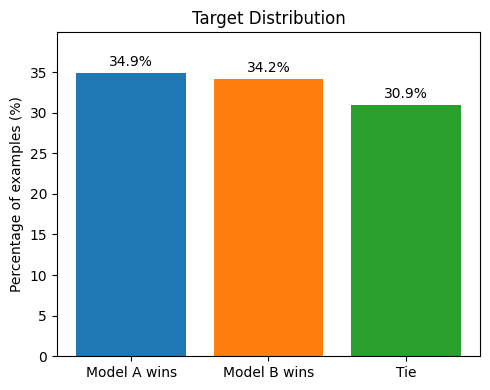

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# If you don't already have this:
# train["label"] = train[["winner_model_a","winner_model_b","winner_tie"]].values.argmax(axis=1)

# Compute normalized distribution
dist = train["label"].value_counts(normalize=True).sort_index()
# Convert to percentages
percentages = (dist * 100).round(1)

labels = ["Model A wins", "Model B wins", "Tie"]
values = percentages.values  # e.g. [35.0, 34.0, 31.0]

plt.figure(figsize=(5,4))
bars = plt.bar(labels, values, color=["tab:blue", "tab:orange", "tab:green"])
plt.ylabel("Percentage of examples (%)")
plt.title("Target Distribution")

# Add value labels on top of bars
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f"{val}%", ha="center", va="bottom", fontsize=10)

plt.ylim(0, max(values) + 5)
plt.tight_layout()
plt.show()


In [9]:
# Create label and basic text length features
import pandas as pd
import numpy as np
import re

# 0 = A wins, 1 = B wins, 2 = tie
label_cols = ["winner_model_a","winner_model_b","winner_tie"]
train["label"] = train[label_cols].values.argmax(axis=1)

def simple_tokenize(text):
    if not isinstance(text, str):
        return []
    return re.findall(r"\w+", text.lower())

# character lengths
train["len_prompt_char"] = train["prompt"].astype(str).str.len()
train["len_a_char"]      = train["response_a"].astype(str).str.len()
train["len_b_char"]      = train["response_b"].astype(str).str.len()

# token counts
train["len_prompt_tok"] = train["prompt"].astype(str).apply(lambda x: len(simple_tokenize(x)))
train["len_a_tok"]      = train["response_a"].astype(str).apply(lambda x: len(simple_tokenize(x)))
train["len_b_tok"]      = train["response_b"].astype(str).apply(lambda x: len(simple_tokenize(x)))


In [10]:
# Show first 5 rows of the new length features
print(train[["prompt",
             "len_prompt_char", "len_a_char", "len_b_char",
             "len_prompt_tok", "len_a_tok", "len_b_tok"]].head())


                                              prompt  len_prompt_char  \
0  ["Is it morally right to try to have a certain...              165   
1  ["What is the difference between marriage lice...              200   
2  ["explain function calling. how would you call...               60   
3  ["How can I create a test set for a very rare ...               87   
4  ["What is the best way to travel from Tel-Aviv...               79   

   len_a_char  len_b_char  len_prompt_tok  len_a_tok  len_b_tok  
0        4538        1206              29        715        212  
1        3114        3649              36        551        603  
2         921        1835               9        155        302  
3        3182        1562              18        557        275  
4        1300         772              15        240        133  


In [11]:
cols = ["len_prompt_char", "len_a_char", "len_b_char",
        "len_prompt_tok", "len_a_tok", "len_b_tok"]

print(train[cols].describe())


       len_prompt_char    len_a_char    len_b_char  len_prompt_tok  \
count     57477.000000  57477.000000  57477.000000    57477.000000   
mean        369.198584   1377.818919   1386.162169       61.036676   
std        1073.341472   1513.932333   1537.800488      170.090692   
min           7.000000      4.000000      4.000000        1.000000   
25%          52.000000    408.000000    413.000000        9.000000   
50%          96.000000   1076.000000   1086.000000       17.000000   
75%         243.000000   1862.000000   1873.000000       43.000000   
max       33056.000000  54058.000000  53830.000000     4917.000000   

          len_a_tok     len_b_tok  
count  57477.000000  57477.000000  
mean     228.351045    229.422865  
std      244.139720    246.671268  
min        0.000000      0.000000  
25%       70.000000     71.000000  
50%      183.000000    185.000000  
75%      310.000000    311.000000  
max     9641.000000   8582.000000  


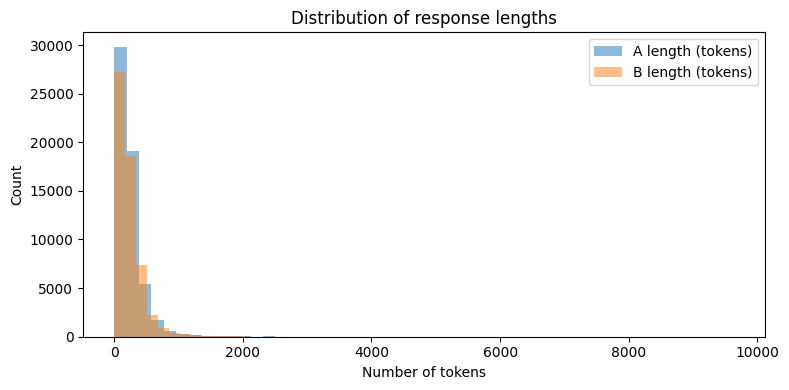

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(train["len_a_tok"], bins=50, alpha=0.5, label="A length (tokens)")
plt.hist(train["len_b_tok"], bins=50, alpha=0.5, label="B length (tokens)")
plt.xlabel("Number of tokens")
plt.ylabel("Count")
plt.title("Distribution of response lengths")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
# 0 = A wins, 1 = B wins, 2 = tie
group_stats = (
    train.groupby("label")[["len_a_tok", "len_b_tok"]]
         .mean()
         .rename(index={0:"A wins",1:"B wins",2:"Tie"})
)

print(group_stats)

#strong Verosity bias


         len_a_tok   len_b_tok
label                         
A wins  258.803030  217.340760
B wins  213.981834  258.807806
Tie     209.849558  210.558077


## 2. Text Length Analysis
We analyzed the word counts of the Prompts and Responses.

- **Prompts**: Generally short (Median: 16 words). Users ask concise questions.
- **Responses**: Longer and more variable (Median: ~170 words).
- **Max Length**: Some responses are extremely long (up to ~8000 words).

**Insight**:
- Most transformer models (like DeBERTa) have a maximum context length (usually 512 or 1024 tokens).
- Since the median response length is ~170 words, `Prompt + Response A + Response B` will typically fit within 512-1024 tokens.
- However, for the very long outliers, we will need to **truncate** the text. We must ensure our tokenizer handles this gracefully so we don't lose the most important parts of the response (usually the beginning and end).

In [14]:
import pandas as pd
import numpy as np

def augment_data(input_path, output_path):
    print(f"Loading data from {input_path}...")
    df = pd.read_csv(input_path)
    original_len = len(df)
    
    print("Creating augmented copy (swapping Response A and B)...")
    df_aug = df.copy()
    
    # Swap responses
    df_aug.rename(columns={
        'response_a': 'temp',
        'response_b': 'response_a',
    }, inplace=True)
    df_aug.rename(columns={
        'temp': 'response_b'
    }, inplace=True)
    
    # Swap target probabilities
    # winner_model_a -> winner_model_b
    # winner_model_b -> winner_model_a
    # winner_tie -> winner_tie (unchanged)
    
    df_aug.rename(columns={
        'winner_model_a': 'temp_win',
        'winner_model_b': 'winner_model_a',
    }, inplace=True)
    df_aug.rename(columns={
        'temp_win': 'winner_model_b'
    }, inplace=True)
    
    # Concatenate original and augmented
    df_final = pd.concat([df, df_aug], axis=0).reset_index(drop=True)
    
    print(f"Original size: {original_len}")
    print(f"Augmented size: {len(df_final)}")
    
    print(f"Saving to {output_path}...")
    df_final.to_csv(output_path, index=False)
    print("Done.")

if __name__ == "__main__":
    augment_data("/kaggle/input/llmclassificationfinetuning/train.csv", "train_augmented.csv")


Loading data from /kaggle/input/llmclassificationfinetuning/train.csv...
Creating augmented copy (swapping Response A and B)...
Original size: 57477
Augmented size: 114954
Saving to train_augmented.csv...
Done.


In [15]:
# import kagglehub

# # Download selected version
# path = kagglehub.model_download("keras/deberta_v3/keras/deberta_v3_extra_small_en/2")

# print("Path to model files:", path)

In [16]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModel, AutoConfig, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from huggingface_hub import hf_hub_download

# --- Configuration ---
class Config:
    model_name = "microsoft/deberta-v3-base"
    max_length = 512
    batch_size = 4        # Adjust if you run out of memory (try 2 if 4 fails)
    lr = 2e-5             # Learning rate
    epochs = 1            # Keep to 1 for initial testing
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42

# Set seed for reproducibility
torch.manual_seed(Config.seed)
print(f"Using device: {Config.device}")

# --- Helper: Manual Tokenizer Download (Fixes 404 Error) ---
def download_tokenizer(model_name, save_path="local_tokenizer"):
    """Downloads tokenizer files manually to bypass AutoTokenizer 404 errors."""
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # Files needed for DeBERTa v3 tokenizer
    files = ["tokenizer_config.json", "spm.model", "tokenizer.json", "special_tokens_map.json", "config.json"]
    print(f"Downloading tokenizer files to {save_path}...")
    
    for filename in files:
        try:
            hf_hub_download(repo_id=model_name, filename=filename, local_dir=save_path)
        except Exception as e:
            print(f"Skipping {filename} (might not exist, which is fine): {e}")
            
    return save_path

# --- Dataset Class ---
class PreferenceDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512, is_test=False):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_test = is_test
        
    def __len__(self):
        return len(self.df)
    
    def clean_text(self, text):
        # Handle list-string format from CSV
        try:
            import json
            text_list = json.loads(text)
            return " ".join(text_list)
        except:
            return str(text)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        prompt = self.clean_text(row['prompt'])
        res_a = self.clean_text(row['response_a'])
        res_b = self.clean_text(row['response_b'])
        
        # Format: [CLS] Prompt [SEP] Response A [SEP] Response B [SEP]
        text = f"{prompt} {self.tokenizer.sep_token} {res_a} {self.tokenizer.sep_token} {res_b}"
        
        inputs = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        item = {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
        }
        
        if not self.is_test:
            # Targets: 0=A, 1=B, 2=Tie
            probs = row[['winner_model_a', 'winner_model_b', 'winner_tie']].values.astype('float32')
            item['labels'] = torch.tensor(probs)
            
        return item

# --- Model Class ---
class PreferenceModel(nn.Module):
    def __init__(self, model_name, num_classes=3):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        # Use [CLS] token embedding
        cls_emb = outputs.last_hidden_state[:, 0, :]
        cls_emb = self.dropout(cls_emb)
        logits = self.classifier(cls_emb)
        return logits

# --- Main Training Loop ---
def run_training():
    # 1. Download & Load Tokenizer
    local_tokenizer_path = download_tokenizer(Config.model_name)
    print("Loading tokenizer from local path...")
    tokenizer = AutoTokenizer.from_pretrained(local_tokenizer_path, use_fast=False)

    # 2. Load Data
    print("Loading data...")
    if not os.path.exists("train_augmented.csv"):
        print("Error: train_augmented.csv not found. Please run the augmentation cell first.")
        return

    df_all = pd.read_csv("train_augmented.csv")
    
    # Split Train/Val
    train_df, val_df = train_test_split(df_all, test_size=0.1, random_state=Config.seed)
    print(f"Train size: {len(train_df)}, Val size: {len(val_df)}")

    train_ds = PreferenceDataset(train_df, tokenizer, Config.max_length)
    val_ds = PreferenceDataset(val_df, tokenizer, Config.max_length)

    train_loader = DataLoader(train_ds, batch_size=Config.batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=Config.batch_size, shuffle=False, num_workers=2)

    # 3. Init Model
    print("Initializing model...")
    model = PreferenceModel(Config.model_name)
    model.to(Config.device)

    # 4. Optimizer & Scheduler
    optimizer = AdamW(model.parameters(), lr=Config.lr)
    total_steps = len(train_loader) * Config.epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    loss_fn = nn.CrossEntropyLoss()

    # 5. Training Loop
    print("Starting training...")
    for epoch in range(Config.epochs):
        model.train()
        total_loss = 0
        
        bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.epochs}")
        for batch in bar:
            input_ids = batch['input_ids'].to(Config.device)
            mask = batch['attention_mask'].to(Config.device)
            labels = batch['labels'].to(Config.device)
            
            optimizer.zero_grad()
            logits = model(input_ids, mask)
            
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
            bar.set_postfix(loss=loss.item())
            
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} - Avg Train Loss: {avg_loss:.4f}")
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(Config.device)
                mask = batch['attention_mask'].to(Config.device)
                labels = batch['labels'].to(Config.device)
                
                logits = model(input_ids, mask)
                loss = loss_fn(logits, labels)
                val_loss += loss.item()
                
        print(f"Epoch {epoch+1} - Val Loss: {val_loss/len(val_loader):.4f}")

    # 6. Save Model
    torch.save(model.state_dict(), "model.pth")
    print("Training Complete! Model saved to model.pth")

# Run it!
if __name__ == "__main__":
    run_training()

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Skipping tokenizer.json (might not exist, which is fine): 404 Client Error. (Request ID: Root=1-692c9134-4330fe530213c0c6407a012f;40966e4f-13f3-40b9-a93c-2572b8c71120)

Entry Not Found for url: https://huggingface.co/microsoft/deberta-v3-base/resolve/main/tokenizer.json.
Skipping special_tokens_map.json (might not exist, which is fine): 404 Client Error. (Request ID: Root=1-692c9134-6929444176d4d9190f161413;7ca32461-39ea-4bb9-9a7c-30d5acf768a9)

Entry Not Found for url: https://huggingface.co/microsoft/deberta-v3-base/resolve/main/special_tokens_map.json.


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

Loading tokenizer from local path...


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loading data...
Train size: 103458, Val size: 11496
Initializing model...


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Starting training...


Epoch 1/1:   0%|          | 0/25865 [00:00<?, ?it/s]

Epoch 1 - Avg Train Loss: 1.0851
Epoch 1 - Val Loss: 1.0694
Training Complete! Model saved to model.pth
